# **Sistem Rekomendasi Proyek Machine Learning Terapan**
- **Nama:** Muhammad Makarim
- **Email:** mmakarim9@student.ub.ac.id
- **ID Dicoding:** MC006D5Y1427

## **Import Semua Packages/Library yang Digunakan**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import kagglehub
import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

## **Data Preparation**

### **Data Loading**

In [2]:
# Download latest version
path = kagglehub.dataset_download("CooperUnion/anime-recommendations-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/anime-recommendations-database


In [3]:
data_dir = '/kaggle/input/anime-recommendations-database'

In [4]:
anime_csv  = os.path.join(data_dir, "anime.csv")
rating_csv = os.path.join(data_dir, "rating.csv")

In [5]:
df_anime  = pd.read_csv(anime_csv)
df_rating = pd.read_csv(rating_csv)

In [6]:
# Mengecek shape df_anime
print("Shape df_anime:", df_anime.shape)

# Mengecek shape df_rating
print("Shape df_rating:", df_rating.shape)

Shape df_anime: (12294, 7)
Shape df_rating: (7813737, 3)


In [7]:
df_rating = df_rating.sample(frac=0.01, random_state=42)

In [8]:
# Mengecek shape df_rating
print("Shape df_rating:", df_rating.shape)

Shape df_rating: (78137, 3)


In [9]:
display(df_anime.head())

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [10]:
display(df_rating.head())

,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8


## **Data Understanding**

Di bagian ini, kita uraikan asal data, struktur tabel, dan insight awal melalui eksplorasi

### **Jumlah record & contoh data**

In [11]:
print(f"Jumlah record anime : {df_anime.shape[0]:,}")
print(f"Jumlah record rating: {df_rating.shape[0]:,}\n")

print("Contoh 5 baris pertama (anime.csv):")
display(df_anime.head(5))
print("\nContoh 5 baris pertama (rating.csv):")
display(df_rating.head(5))

Jumlah record anime : 12,294
Jumlah record rating: 78,137

Contoh 5 baris pertama (anime.csv):


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266



Contoh 5 baris pertama (rating.csv):


,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8


### **Daftar fitur & tipe data**

In [12]:
print("\nFitur anime.csv:")
for col, dtype in zip(df_anime.columns, df_anime.dtypes):
    print(f" - {col}: {dtype}")
print("\nFitur rating.csv:")
for col, dtype in zip(df_rating.columns, df_rating.dtypes):
    print(f" - {col}: {dtype}")


Fitur anime.csv:
 - anime_id: int64
 - name: object
 - genre: object
 - type: object
 - episodes: object
 - rating: float64
 - members: int64

Fitur rating.csv:
 - user_id: int64
 - anime_id: int64
 - rating: int64


### **Cek missing values**

In [13]:
print("\nMissing values (anime.csv):")
print(df_anime.isnull().sum())
print("\nMissing values (rating.csv):")
print(df_rating.isnull().sum())


Missing values (anime.csv):
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Missing values (rating.csv):
user_id     0
anime_id    0
rating      0
dtype: int64


### **Cek Duplikasi Data**

In [14]:
duplicate_count = df_anime.duplicated().sum()
print(f"Jumlah data duplikat df_anime: {duplicate_count}")
duplicate_count = df_rating.duplicated().sum()
print(f"Jumlah data duplikat df_rating: {duplicate_count}")

Jumlah data duplikat df_anime: 0
Jumlah data duplikat df_rating: 0


### **Statistik deskriptif dasar**

In [15]:
print("\nDescriptive statistics (anime.csv):")
display(df_anime.describe())
print("\nDescriptive statistics (rating.csv):")
display(df_rating.describe())


Descriptive statistics (anime.csv):


,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06



Descriptive statistics (rating.csv):


,user_id,anime_id,rating
count,78137.000000,78137.000000,78137.000000
mean,36794.320194,8932.466501,6.152181
std,20955.911781,8909.022204,3.727610
min,1.000000,1.000000,-1.000000
25%,19031.000000,1241.000000,6.000000
50%,37016.000000,6213.000000,7.000000
75%,54713.000000,14075.000000,9.000000
max,73515.000000,34240.000000,10.000000


### **Insight awal**

In [16]:
n_users  = df_rating['user_id'].nunique()
n_anime  = df_rating['anime_id'].nunique()
zero_click = (df_rating['rating'] == 0).sum()
print(f"\nJumlah user unik      : {n_users:,}")
print(f"Jumlah anime unik     : {n_anime:,}")
print(f"Jumlah implicit clicks (rating=0): {zero_click:,}")


Jumlah user unik      : 33,919
Jumlah anime unik     : 5,408
Jumlah implicit clicks (rating=0): 0


## **Exploratory Data Analysis**

### **Distribusi Rating Pengguna**

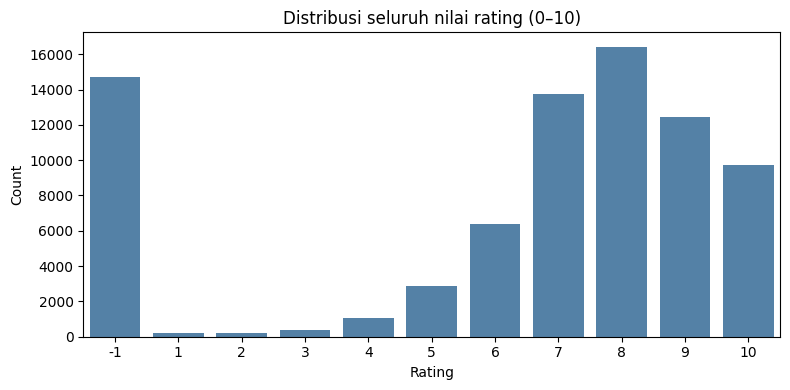

In [17]:
plt.figure(figsize=(8,4))
sns.countplot(data=df_rating, x='rating', color='steelblue')
plt.title('Distribusi seluruh nilai rating (0–10)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(0,11))
plt.tight_layout()
plt.show()

Visualisasi ini menampilkan *count plot* (plot hitungan) dari kolom rating di *DataFrame* df_rating.
*   Judul Plot: "Distribusi seluruh nilai rating (0-10)" menunjukkan bahwa plot ini menampilkan sebaran nilai rating yang diberikan pengguna, mulai dari 0 hingga 10.
*   Sumbu X: Label "Rating" menunjukkan bahwa sumbu horizontal merepresentasikan nilai rating yang diberikan oleh pengguna.
*   Sumbu Y: Label "Count" menunjukkan bahwa sumbu vertikal merepresentasikan jumlah data (jumlah rating) untuk setiap nilai rating yang ada.

Dari plot ini, dapat melihat frekuensi setiap nilai rating. Biasanya, plot ini akan menunjukkan bahwa beberapa nilai rating lebih sering diberikan daripada yang lain. Khususnya, nilai rating 0 seringkali merepresentasikan implicit clicks atau views tanpa memberikan rating eksplisit, dan frekuensinya mungkin sangat tinggi dibandingkan rating 1-10. Rating 1-10 adalah rating eksplisit yang diberikan pengguna.

### **Rating Korelasi**

In [18]:
# Korelasi numerik: episodes, members, score
num_df = df_anime[['episodes','members','rating']].copy()

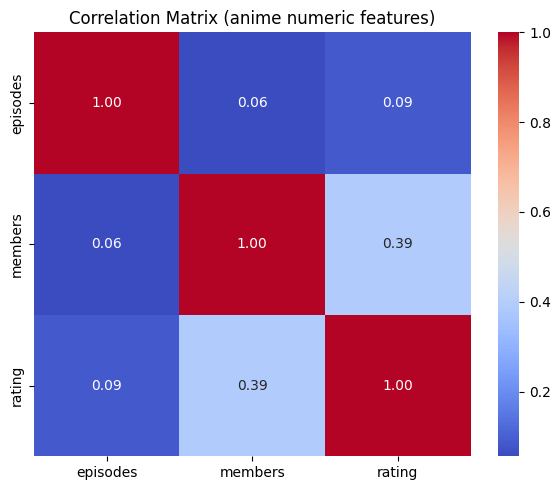

In [19]:
# Ubah episodes ke numerik, drop invalid
num_df['episodes'] = pd.to_numeric(num_df['episodes'], errors='coerce')
num_df = num_df.replace(0, pd.NA).dropna()

plt.figure(figsize=(6,5))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (anime numeric features)')
plt.tight_layout()
plt.show()

*   **Proses:** Bagian ini memilih kolom episodes, members, dan rating dari df_anime. Kolom episodes diubah menjadi tipe numerik. Nilai 0 dan missing values dihapus karena tidak relevan untuk analisis korelasi numerik. Kemudian, dihitung matriks korelasi antar kolom-kolom numerik tersebut.
*   **Visualisasi:** Matriks korelasi divisualisasikan menggunakan heatmap.
  *   Setiap sel dalam heatmap menunjukkan nilai korelasi antara dua fitur.
  *   Nilai korelasi berkisar antara -1 hingga +1.
  *   Nilai mendekati +1 menunjukkan korelasi positif yang kuat (jika satu nilai naik, yang lain cenderung naik).
  *   Nilai mendekati -1 menunjukkan korelasi negatif yang kuat (jika satu nilai naik, yang lain cenderung turun).
  *   Nilai mendekati 0 menunjukkan korelasi lemah atau tidak ada korelasi linier.
  *   Warna heatmap (cmap='coolwarm') akan membantu membedakan nilai korelasi (misalnya, warna biru untuk korelasi negatif, merah untuk korelasi positif).
  *   annot=True akan menampilkan nilai korelasi pada setiap sel heatmap.

Hasil dari heatmap ini akan menunjukkan seberapa kuat hubungan linier antara jumlah episode, jumlah anggota komunitas (members), dan rata-rata rating sebuah anime. Misalnya, jika ada korelasi positif yang kuat antara members dan rating, itu bisa berarti anime yang punya banyak anggota komunitas cenderung memiliki rating yang lebih tinggi.





### **Top-N Anime berdasarkan Jumlah Rating & Rata-Rata Rating**

**rating >0**

In [20]:
agg = df_rating[df_rating.rating>0] \
      .groupby('anime_id')['rating'] \
      .agg(['count','mean']) \
      .reset_index() \
      .merge(df_anime[['anime_id','name']], on='anime_id')

*   **Proses**: Kode ini terlebih dahulu memfilter rating yang bernilai > 0 (mengabaikan implicit clicks). Kemudian, data rating dikelompokkan berdasarkan anime_id. Untuk setiap anime_id, dihitung jumlah rating (count) dan rata-rata rating (mean). Hasilnya kemudian digabungkan dengan DataFrame df_anime untuk mendapatkan nama anime. Hasilnya disimpan dalam DataFrame agg.

**Top 10 by count**

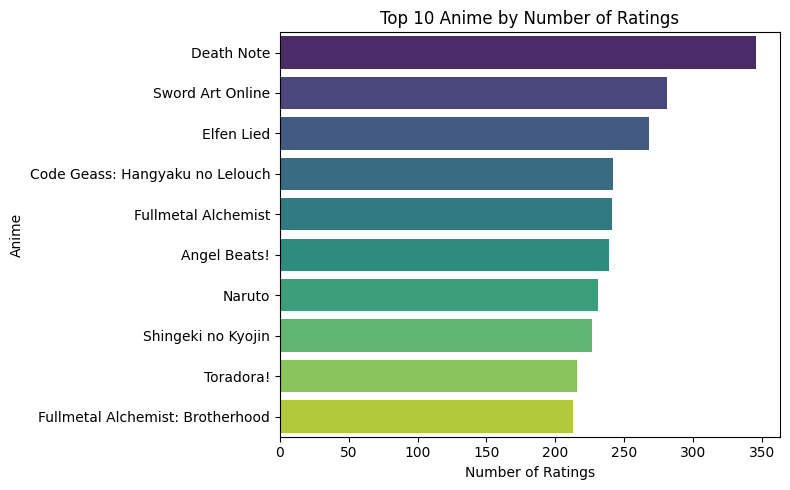

In [21]:
top_count = agg.nlargest(10, 'count')
plt.figure(figsize=(8,5))
sns.barplot(data=top_count, x='count', y='name', palette='viridis')
plt.title('Top 10 Anime by Number of Ratings')
plt.xlabel('Number of Ratings')
plt.ylabel('Anime')
plt.tight_layout()
plt.show()

*   Proses: Memilih 10 anime teratas dari DataFrame agg berdasarkan kolom count (jumlah rating).
*   Visualisasi: Hasilnya divisualisasikan menggunakan bar plot.
  *   Sumbu X: "Number of Ratings" (Jumlah Rating).
  *   Sumbu Y: "Anime" (Nama Anime).
  *   Plot ini akan menampilkan 10 anime dengan jumlah rating terbanyak, memberikan insight tentang anime mana yang paling populer atau paling banyak ditonton/diberi rating oleh pengguna.

**Top 10 by average rating (with min count threshold)**

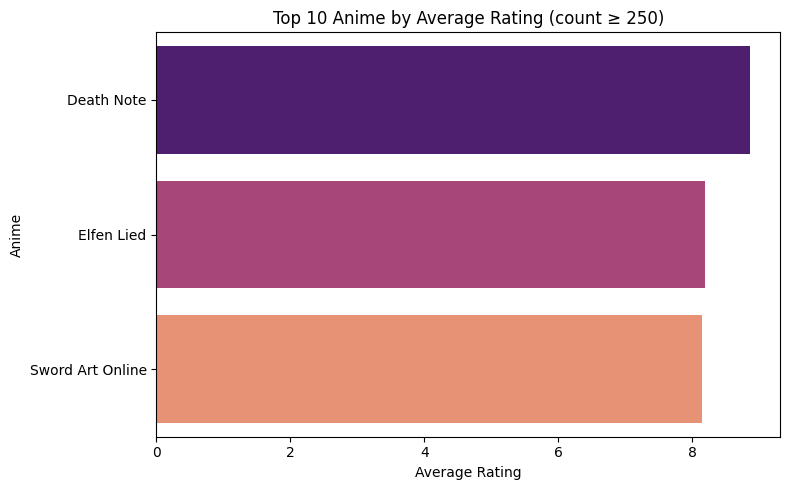

In [22]:
min_count = 250
top_mean = agg[agg['count']>=min_count].nlargest(10, 'mean')
plt.figure(figsize=(8,5))
sns.barplot(data=top_mean, x='mean', y='name', palette='magma')
plt.title(f'Top 10 Anime by Average Rating (count ≥ {min_count})')
plt.xlabel('Average Rating')
plt.ylabel('Anime')
plt.tight_layout()
plt.show()

*   Proses: Memilih anime dari DataFrame agg yang memiliki jumlah rating (count) minimal 250 (nilai min_count). Dari anime yang memenuhi syarat ini, kemudian dipilih 3 anime teratas berdasarkan rata-rata rating (mean). Batasan jumlah rating minimum (min_count) digunakan agar rata-rata rating yang tinggi tidak didominasi oleh anime yang hanya memiliki sedikit rating (yang mungkin tidak mencerminkan popularitas atau kualitas sebenarnya secara luas).
*   Visualisasi: Hasilnya divisualisasikan menggunakan bar plot
  *   Sumbu X: "Average Rating" (Rata-Rata Rating).
  *   Sumbu Y: "Anime" (Nama Anime).
  *   Plot ini akan menampilkan anime yang dianggap memiliki kualitas terbaik berdasarkan rata-rata rating dari sejumlah besar pengguna.

### **Genre Explosion & Top Genres**

**All Genre**

In [24]:
genre_set = set()
for genre_string in df_anime['genre'].dropna():
    genres = genre_string.split('|')
    genre_set.update(genres)

print("Total of unique genre:", len(genre_set))
print("list of unique genre:")
for genre in sorted(genre_set):
    print("-", genre)

Total of unique genre: 3128
list of unique genre:
- Action
- Action, Adventure
- Action, Adventure, Cars, Comedy, Sci-Fi, Shounen
- Action, Adventure, Cars, Mecha, Sci-Fi, Shounen, Sports
- Action, Adventure, Cars, Sci-Fi
- Action, Adventure, Comedy
- Action, Adventure, Comedy, Demons, Drama, Ecchi, Horror, Mystery, Romance, Sci-Fi
- Action, Adventure, Comedy, Demons, Fantasy, Magic
- Action, Adventure, Comedy, Demons, Fantasy, Magic, Romance, Shounen, Supernatural
- Action, Adventure, Comedy, Demons, Fantasy, Martial Arts, Shounen, Super Power
- Action, Adventure, Comedy, Demons, Magic, Super Power
- Action, Adventure, Comedy, Demons, Shounen, Supernatural
- Action, Adventure, Comedy, Demons, Supernatural, Vampire
- Action, Adventure, Comedy, Drama
- Action, Adventure, Comedy, Drama, Ecchi, Fantasy, Harem, Magic, Romance, School
- Action, Adventure, Comedy, Drama, Ecchi, Mecha, Romance, Sci-Fi
- Action, Adventure, Comedy, Drama, Fantasy, Historical
- Action, Adventure, Comedy, Drama, 

**Top 20 Genre**

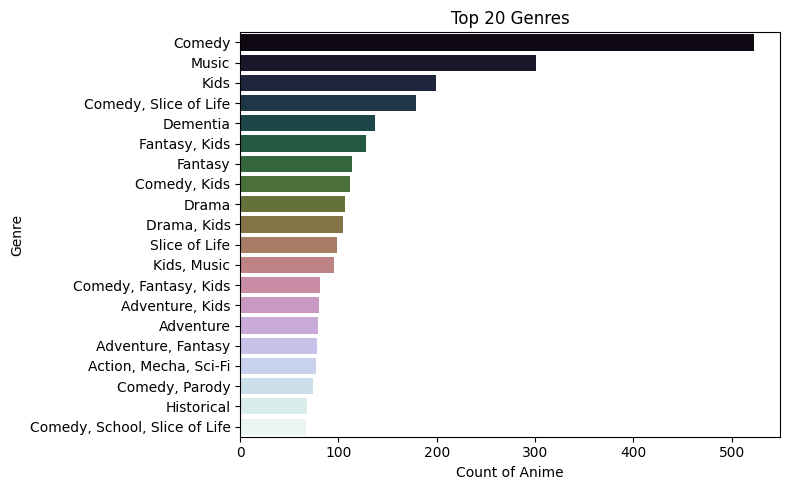

In [25]:
genre_exploded = df_anime['genre'].dropna().str.split('|').explode()
top_genres = genre_exploded.value_counts().head(20)
plt.figure(figsize=(8,5))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='cubehelix')
plt.title('Top 20 Genres')
plt.xlabel('Count of Anime')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

*   Proses:
  *   Pertama mengekstrak semua genre unik dari kolom genre di df_anime. Kolom genre berisi string yang dipisahkan oleh karakter |. String ini dipecah menjadi genre-genre individual, dan semua genre unik dikumpulkan ke dalam sebuah set. Jumlah genre unik dan daftarnya kemudian dicetak.
  *   Kedua melakukan proses yang serupa dengan memecah string genre, tetapi menggunakan fungsi explode() dari pandas untuk membuat setiap genre menjadi baris terpisah. Kemudian, dihitung frekuensi setiap genre (value_counts()) dan diambil 20 genre teratas.
*   Visualisasi: 20 genre teratas divisualisasikan menggunakan bar plot.
  *   Sumbu X: "Count of Anime" (Jumlah Anime).
  *   Sumbu Y: "Genre" (Nama Genre).
  *   Plot ini akan menunjukkan genre-genre yang paling sering muncul dalam dataset anime, memberikan insight tentang jenis anime apa yang paling banyak tersedia.

### **Tipe Anime**

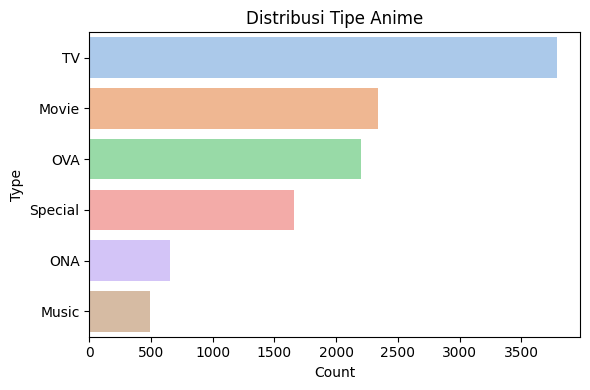

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_anime, y='type',
              order=df_anime['type'].value_counts().index,
              palette='pastel')
plt.title('Distribusi Tipe Anime')
plt.xlabel('Count')
plt.ylabel('Type')
plt.tight_layout()
plt.show()

*   Proses: Kode ini menghitung frekuensi setiap nilai unik dalam kolom type di df_anime. Urutan batang pada plot diatur berdasarkan frekuensi dari yang terbanyak ke yang tersedikit.
*   Visualisasi: Hasilnya divisualisasikan menggunakan bar plot.
  *   Sumbu X: "Count" (Jumlah).
  *   Sumbu Y: "Type" (Tipe Anime).
  *   Plot ini akan menunjukkan jenis-jenis anime apa yang paling umum dalam dataset, misalnya apakah anime berformat TV series paling banyak atau ada tipe lain yang dominan.

Secara keseluruhan, bagian EDA ini memberikan pemahaman awal yang penting tentang data yang digunakan, termasuk pola rating pengguna, hubungan antar fitur anime, anime terpopuler dan terbaik, genre yang dominan, dan distribusi tipe anime. Informasi ini sangat berguna untuk langkah-langkah selanjutnya dalam pembuatan sistem rekomendasi.

## **Data Preprocessing**

### **Cleaning Data dari Missing Value**

**Data Anime**

In [27]:
df_anime['genre']    = df_anime['genre'].fillna('')
df_anime['type']     = df_anime['type'].fillna('Unknown')
df_anime['episodes'] = (pd.to_numeric(df_anime['episodes'], errors='coerce')
                         .fillna(0).astype(int))
df_anime['members']  = df_anime['members'].fillna(0).astype(int)

mean_score = df_anime['rating'].mean()
df_anime['rating']    = df_anime['rating'].fillna(mean_score)

**Data Rating**

In [28]:
# Cleaning rating data
df_rating['rating'] = pd.to_numeric(df_rating['rating'], errors='coerce')
df_rating = df_rating.dropna(subset=['rating'])

# Split explicit vs implicit
df_rating_cf  = df_rating[df_rating.rating > 0].copy()
df_rating_imp = df_rating[df_rating.rating == 0].copy()

# Filter batas minimum interaksi
min_per_user  = 20
min_per_anime = 20

active_u = df_rating_cf['user_id'].value_counts()
active_a = df_rating_cf['anime_id'].value_counts()

keep_users = active_u[active_u >= min_per_user].index
keep_anime  = active_a[active_a >= min_per_anime].index

df_rating_cf = df_rating_cf[
    df_rating_cf.user_id.isin(keep_users) &
    df_rating_cf.anime_id.isin(keep_anime)
].reset_index(drop=True)

**Cek Missing Values**

In [29]:
print("\nMissing values (anime.csv):")
print(df_anime.isnull().sum())
print("\nMissing values (rating.csv):")
print(df_rating.isnull().sum())


Missing values (anime.csv):
anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Missing values (rating.csv):
user_id     0
anime_id    0
rating      0
dtype: int64


### **Feature Engineering (Content-Based)**

In [30]:
# Inisialisasi TF-IDF untuk kolom genre
tfidf = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")
tfidf_matrix = tfidf.fit_transform(df_anime['genre'])

# Mapping anime_id ↔ index matriks
anime_idx_map = pd.Series(df_anime.index, index=df_anime['anime_id'])

## **Model Development dengan Content Based Filtering**

Dalam pendekatan content-based filtering, kita memanfaatkan fitur tiap anime (genre, type, episodes, members, score) untuk membangun rekomendasi berdasarkan kemiripan konten.

### **Representasi Fitur**

In [31]:
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


**TF-IDF matrix untuk genre**

In [32]:
tfidf_matrix = tfidf.fit_transform(df_anime['genre'])

**Scaling fitur numerik: rating & members**



In [33]:
scaler = MinMaxScaler()
num_features = scaler.fit_transform(df_anime[['rating', 'members']])

**Gabungkan vektor teks & numerik**

In [34]:
from scipy.sparse import hstack
feature_matrix = hstack([tfidf_matrix, np.array(num_features)])

### **Hitung Similarity**

In [35]:
cosine_sim = cosine_similarity(feature_matrix, feature_matrix)

### **Fungsi Rekomendasi**

**Membuat Fungsi dan Visualisasi Fungsi Rekomendasi**

In [36]:
def recommend_content_verbose(anime_id, top_n=5):
    # Cari index target
    idx = anime_idx_map[anime_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Pilih top_n teratas (kecuali sendiri)
    top = sim_scores[1 : top_n+1]
    rec_indices = [i for i, _ in top]
    rec_sims    = [s for _, s in top]

    # Tampilkan detail target anime
    target = df_anime[df_anime['anime_id']==anime_id].iloc[0]
    print(f"=== Target Anime (ID={anime_id}) ===")
    display(target[['name','genre','type','episodes','members','rating']])

    # Kumpulkan detail rekomendasi
    recs = df_anime.iloc[rec_indices].copy()
    recs['similarity'] = rec_sims
    recs = recs[['anime_id','name','genre','type','episodes','members','rating','similarity']]

    print(f"\n=== Top {top_n} Recommendations ===")
    display(recs.reset_index(drop=True))

    # Visualisasi similarity
    plt.figure(figsize=(10,4))
    sns.barplot(data=recs, x='similarity', y='name', palette='viridis')
    plt.title(f'Similarity to "{target["name"]}"')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Cosine Similarity')
    plt.xlabel('Recommended Anime')
    plt.tight_layout()
    plt.show()

    return recs

**Mencoba Fungsi Rekomendasi**

Percobaan 1

=== Target Anime (ID=1) ===


,22
name,Cowboy Bebop
genre,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
type,TV
episodes,26
members,486824
rating,8.82



=== Top 10 Recommendations ===


,anime_id,name,genre,type,episodes,members,rating,similarity
0,4037,Cowboy Bebop: Yose Atsume Blues,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Special,1,19565,7.53,0.940518
1,2202,Waga Seishun no Arcadia,"Action, Adventure, Drama, Sci-Fi, Space",Movie,1,4415,7.70,0.919249
2,400,Seihou Bukyou Outlaw Star,"Action, Adventure, Comedy, Sci-Fi, Space",TV,24,78600,7.98,0.918966
3,2203,Waga Seishun no Arcadia: Mugen Kidou SSX,"Action, Adventure, Drama, Sci-Fi, Space",TV,22,2587,7.56,0.917691
4,1490,Ginga Tetsudou Monogatari,"Action, Adventure, Drama, Sci-Fi, Space",TV,26,5947,7.29,0.916194
5,2470,Uchuu Kaizoku Captain Harlock: Arcadia-gou no ...,"Action, Adventure, Drama, Sci-Fi, Space",Movie,1,2579,7.18,0.914120
6,2717,Ginga Tetsudou Monogatari: Eien e no Bunkiten,"Action, Adventure, Drama, Sci-Fi, Space",TV,24,2072,7.09,0.912976
7,1491,Ginga Tetsudou 999,"Adventure, Drama, Sci-Fi, Space",TV,113,12672,7.90,0.892616
8,17269,Captain Harlock,"Action, Drama, Sci-Fi, Space",Movie,1,25484,7.56,0.888007
9,2929,Moonlight Mile 2nd Season: Touch Down,"Adventure, Drama, Sci-Fi, Space",TV,14,2758,7.51,0.886532


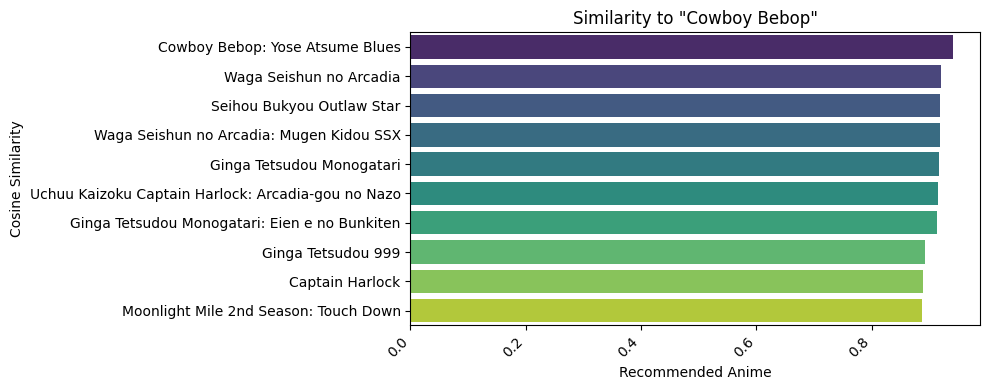

In [37]:
recs_for_1 = recommend_content_verbose(anime_id=1, top_n=10)

Percobaan 2 (menggunakan random untuk anime_id)

In [38]:
import random

random.seed(42)
all_ids = df_anime['anime_id'].tolist()
rand_id = random.choice(all_ids)

=== Target Anime (ID=19843) ===


,10476
name,Tamagotchi! Miracle Friends
genre,"Comedy, Fantasy, Kids"
type,TV
episodes,29
members,207
rating,7.0



=== Top 10 Recommendations ===


,anime_id,name,genre,type,episodes,members,rating,similarity
0,23107,GO-GO Tamagotchi!,"Comedy, Fantasy, Kids",TV,50,198,7.17,0.999897
1,2651,Doraemon: Doraemon Comes Back (Movie),"Comedy, Fantasy, Kids",Movie,1,672,7.18,0.999885
2,10115,Friends: Mononoke Shima no Naki,"Comedy, Fantasy, Kids",Movie,1,601,7.19,0.999872
3,4101,Wan Wan Celepoo Soreyuke! Tetsunoshin,"Comedy, Fantasy, Kids",TV,51,432,6.81,0.999866
4,5526,Pokemon: Pikachu no Natsuyasumi,"Comedy, Fantasy, Kids",Movie,1,19960,6.86,0.999791
5,32676,Sore Ike! Anpanman: Omocha no Hoshi no Nanda t...,"Comedy, Fantasy, Kids",Movie,1,72,7.25,0.999779
6,30232,Tamagotchi! Tamatomo Daishuu GO,"Comedy, Fantasy, Kids",TV,26,187,6.75,0.999767
7,29901,Sore Ike! Anpanman: Mija to Mahou no Lamp,"Comedy, Fantasy, Kids",Movie,1,85,6.75,0.999767
8,10059,Sore Ike! Anpanman: Tsumiki Shiro no Himitsu,"Comedy, Fantasy, Kids",Movie,1,130,6.73,0.999728
9,5529,Pokemon: Odoru Pokemon Himitsu Kichi,"Comedy, Fantasy, Kids",Movie,1,5846,6.72,0.999696


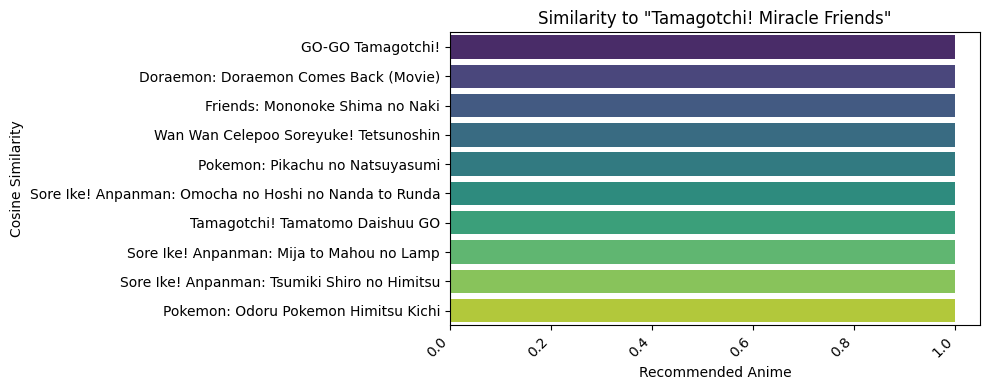

In [39]:
recs_for_random = recommend_content_verbose(anime_id=rand_id, top_n=10)

### **Kelebihan & Kekurangan Model Development dengan Content Based Filtering**

Model rekomendasi berbasis konten *Content-Based Filtering* bekerja dengan merekomendasikan item kepada pengguna berdasarkan kemiripan atribut atau fitur dari item yang disukai pengguna di masa lalu. Berikut adalah kelebihan dan kekurangannya:

**Kelebihan Content-Based Filtering**
1. Tidak Membutuhkan Data Pengguna Lain *Independence from other users*:

  Model ini hanya memerlukan data historis preferensi satu pengguna (item apa yang disukai, rating yang diberikan) dan fitur-fitur dari item itu sendiri. Ini sangat menguntungkan untuk pengguna baru atau item baru (cold-start problem) karena model tetap bisa memberikan rekomendasi asalkan ada sedikit informasi preferensi dari pengguna tersebut atau fitur dari item tersebut.
2. Kemampuan Merekomendasikan Item Baru *Novelty*:

  Content-based filtering dapat merekomendasikan item yang belum pernah dilihat atau diberi rating oleh pengguna lain, selama item tersebut memiliki fitur yang mirip dengan item yang disukai pengguna. Ini berbeda dengan Collaborative Filtering yang cenderung merekomendasikan item yang sudah populer atau sering berinteraksi.
3. Sangat Berguna untuk Item dengan Fitur Kaya *Rich Features*:

  Model ini bekerja sangat baik ketika item memiliki deskripsi atau atribut yang detail (misalnya, genre film, deskripsi produk, kata kunci artikel). Semakin kaya fitur item, semakin akurat kemiripan antar item dapat dihitung.


**Kekurangan Content-Based Filtering**
1. Over-specialization *Filter Bubble*:

  Model ini cenderung merekomendasikan item yang sangat mirip dengan item yang sudah disukai pengguna. Hal ini bisa membatasi pengguna dalam menemukan item baru yang berada di luar selera mereka saat ini, menciptakan "gelembung filter" di mana pengguna terus-menerus terpapar pada jenis konten yang sama.
2. Keterbatasan pada Fitur Item *Limited Content Analysis*:

  Kualitas rekomendasi sangat bergantung pada seberapa baik fitur-fitur item merepresentasikan konten atau daya tarik item tersebut. Jika fitur yang tersedia kurang informatif atau tidak menangkap semua aspek relevan dari item, rekomendasi bisa menjadi kurang akurat atau tidak menarik.
3. Tidak Mempertimbangkan Popularitas atau Kualitas Universal *Ignores Popularity/Quality*:

  Jika fitur item berupa teks (seperti deskripsi, review), model memerlukan teknik pemrosesan bahasa alami (NLP) seperti TF-IDF atau embedding untuk mengubah teks menjadi representasi numerik yang dapat dibandingkan. Ini bisa menambah kompleksitas pada proses pengembangan.


Secara keseluruhan, Content-Based Filtering adalah pendekatan yang kuat, terutama untuk mengatasi masalah cold-start pengguna dan memberikan penjelasan yang jelas. Namun, untuk memberikan rekomendasi yang lebih beragam dan akurat secara sosial, seringkali model ini dikombinasikan dengan pendekatan lain seperti Collaborative Filtering.


### **Evaluasi Menggunakan RMSE**

Bagian untuk mengevaluasi performa model rekomendasi berbasis konten (Content-Based Filtering) yang telah dikembangkan sebelumnya. Metrik evaluasi yang digunakan adalah Root Mean Squared Error (RMSE).

In [69]:
def evaluate_content_based(recommendations_df):
  if recommendations_df.empty:
    print("No recommendations to evaluate.")
    return np.nan

  # Calculate the average rating of the recommended items
  avg_recommended_rating = recommendations_df['rating'].mean()

  # Calculate the mean squared error of recommended anime ratings from their mean
  mse = mean_squared_error([avg_recommended_rating] * len(recommendations_df), recommendations_df['rating'])

  rmse = np.sqrt(mse)

  print(f"RMSE (Avg. rating of recommended items compared to their mean): {rmse:.4f}")

  return rmse

Fungsi ini menerima satu parameter, yaitu recommendations_df. Parameter ini diharapkan adalah DataFrame Pandas yang berisi daftar anime yang direkomendasikan, dan yang terpenting, memiliki kolom rating yang menyimpan nilai rating sebenarnya dari anime tersebut. DataFrame ini kemungkinan besar adalah hasil dari pemanggilan fungsi rekomendasi sebelumnya, seperti recommend_content_verbose.

Tujuan bagian ini untuk menghitung nilai RMSE dari sekumpulan anime yang direkomendasikan. Perlu diperhatikan bahwa cara penghitungan RMSE di sini sedikit spesifik: ia mengukur seberapa jauh rating sebenarnya dari setiap anime yang direkomendasikan menyimpang dari rata-rata rating dari keseluruhan anime yang direkomendasikan dalam set tersebut. Ini bukan evaluasi prediksi rating pengguna, melainkan evaluasi dispersi rating di antara item yang direkomendasikan.



In [ ]:
print("\n--- Evaluation for Recommendation Set 1 ---")
rmse_set1 = evaluate_content_based(recs_for_1)

print("\n--- Evaluation for Recommendation Set 2 (Random) ---")
rmse_set2 = evaluate_content_based(recs_for_random)

Bagian ini menjalankan fungsi evaluate_content_based untuk dua set rekomendasi yang dihasilkan pada langkah Model Development Content-Based sebelumnya. Meskipun kode ini tidak secara eksplisit mencetak nilai rmse_set1 atau rmse_set2 setelah disimpan, pemanggilan fungsi evaluate_content_based di dalam fungsi itu sendiri sudah mencetak hasilnya ke layar.

In [70]:
print("\n--- Evaluation for Recommendation Set 1 ---")
rmse_set1 = evaluate_content_based(recs_for_1)

print("\n--- Evaluation for Recommendation Set 2 (Random) ---")
rmse_set2 = evaluate_content_based(recs_for_random)


--- Evaluation for Recommendation Set 1 ---
RMSE (Avg. rating of recommended items compared to their mean): 0.2728

--- Evaluation for Recommendation Set 2 (Random) ---
RMSE (Avg. rating of recommended items compared to their mean): 0.2138


1. Evaluation for Recommendation Set 1:
  menunjukkan nilai RMSE sebesar 0.2728. Angka ini berarti bahwa, rata-rata, rating aktual dari 10 anime yang direkomendasikan karena dianggap mirip dengan anime ID 1 memiliki perbedaan sekitar 0.2728 poin dari rata-rata rating keseluruhan 10 anime tersebut. Nilai RMSE ini mengindikasikan tingkat variasi rating di dalam set rekomendasi pertama.
2. Evaluation for Recommendation Set 2 (Random):
  Output evaluasi kedua, menunjukkan nilai RMSE sebesar 0.2138. Angka ini berarti bahwa, rata-rata, rating aktual dari 10 anime yang direkomendasikan karena dianggap mirip dengan anime dengan ID acak memiliki perbedaan sekitar 0.2138 poin dari rata-rata rating keseluruhan 10 anime tersebut. Nilai RMSE ini mengindikasikan tingkat variasi rating di dalam set rekomendasi kedua

Dengan membandingkan kedua nilai RMSE, kita melihat bahwa nilai pada Set 2 (0.2138) lebih rendah dari Set 1 (0.2728). Ini menyiratkan bahwa set anime yang direkomendasikan pada Set 2 memiliki rating aktual yang secara internal lebih konsisten atau kurang bervariasi dibandingkan dengan set anime yang direkomendasikan pada Set 1.

## **Model Development dengan Collaborative Filtering**

### **Persiapan Data**

In [40]:
df_rating.head()

,user_id,anime_id,rating
7806172,73424,7785,10
6470262,59789,19769,6
5975474,55960,59,10
7617688,71461,3342,10
5932334,55390,986,8


In [41]:
user_matrix_train = df_rating.pivot_table(index='user_id', columns='anime_id', values='rating').fillna(0) # <-- Updated

In [42]:
user_ids = user_matrix_train.index.tolist()
item_ids = user_matrix_train.columns.tolist()

### **Definisi & Pelatihan Model**

**Model-Based CF: SVD**

In [43]:
from scipy.sparse.linalg import svds
import numpy as np
import pandas as pd

# 1) Decompose dengan k faktor laten
U, sigma_vals, Vt = svds(user_matrix_train.values, k=50)
sigma = np.diag(sigma_vals)

# 2) Rekonstruksi prediksi rating
all_user_pred = np.dot(np.dot(U, sigma), Vt)
pred_df_svd = pd.DataFrame(
    all_user_pred,
    index=user_ids,
    columns=item_ids
)

### **Fungsi Top-N Recommendation**

In [44]:
def get_top_n(pred_df, user_id, n=5):
    # ambil prediksi untuk user_id
    user_preds = pred_df.loc[user_id]
    # ambil item yang belum dirating asli
    already_rated = user_matrix_train.loc[user_id] > 0
    # filter dan urutkan
    recommendations = (
        user_preds[~already_rated]
        .sort_values(ascending=False)
        .head(n)
    )
    return recommendations.index.tolist(), recommendations.values.tolist()

### **Tampilkan Rekomendasi**

In [58]:
from IPython.display import display

In [59]:
def recommend_cf_verbose(user_id, pred_df, df_anime, user_matrix, top_n=5):
    print(f"=== Rekomendasi untuk user_id={user_id} ===")
    # Get items the user has already rated from the training matrix
    already_rated_ids = user_matrix.loc[user_id][user_matrix.loc[user_id] > 0].index.tolist()

    # Display anime the user has already rated (optional, for context)
    if already_rated_ids:
        print("\n--- Anime yang sudah dirating oleh user ---")
        rated_anime = df_anime[df_anime['anime_id'].isin(already_rated_ids)][['anime_id', 'name', 'genre', 'type', 'rating']]
        display(rated_anime.reset_index(drop=True))
    else:
        print("\n--- User belum merating anime apapun di data training ---")

    # Get the top N recommended anime IDs and predicted scores
    rec_ids, rec_scores = get_top_n(pred_df, user_id, n=top_n)

    # Get details of recommended anime
    recs_df = pd.DataFrame({
        'anime_id': rec_ids,
        'predicted_rating': rec_scores
    }).merge(
        df_anime[['anime_id', 'name', 'genre', 'type', 'rating']],
        on='anime_id'
    )

    print(f"\n--- Top {top_n} Rekomendasi CF ---")
    # --- MODIFIKASI BAGIAN INI ---
    # Menggunakan opsi tampilan sementara untuk format float
    with pd.option_context('display.float_format', '{:,.4f}'.format):
         display(recs_df[['anime_id', 'name', 'genre', 'type', 'rating', 'predicted_rating']].reset_index(drop=True))
    # --- AKHIR MODIFIKASI ---


    # Visualisasi Predicted Rating
    plt.figure(figsize=(12, 8))
    sns.barplot(data=recs_df, x='predicted_rating', y='name', palette='coolwarm')
    plt.title(f'Top {top_n} Rekomendasi (Predicted Rating)')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Anime')
    plt.tight_layout()
    plt.show()

**SVD**

Percobaan 1

In [66]:
random.seed(49)
all_ids = df_rating_cf['user_id'].tolist()
rand_id = random.choice(all_ids)

=== Rekomendasi untuk user_id=23247 ===

--- Anime yang sudah dirating oleh user ---


,anime_id,name,genre,type,rating
0,31043,Boku dake ga Inai Machi,"Mystery, Psychological, Seinen, Supernatural",TV,8.65
1,2167,Clannad,"Comedy, Drama, Romance, School, Slice of Life,...",TV,8.30
2,24277,Yowamushi Pedal: Grande Road,"Comedy, Drama, Shounen, Sports",TV,8.28
3,5365,Tsumiki no Ie,Drama,Movie,8.27
4,4059,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen","Drama, Romance, School, Slice of Life",Special,8.14
5,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,7.81
6,905,Dragon Ball Z Movie 12: Fukkatsu no Fusion!! G...,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen",Movie,7.72
7,18893,Aoki Hagane no Arpeggio: Ars Nova,"Action, Sci-Fi, Seinen",TV,7.55
8,25159,Inou-Battle wa Nichijou-kei no Naka de,"Comedy, Romance, School, Slice of Life, Supern...",TV,7.34
9,22859,Takanashi Rikka Kai: Chuunibyou demo Koi ga Sh...,Comedy,Special,7.26



--- Top 5 Rekomendasi CF ---


,anime_id,name,genre,type,rating,predicted_rating
0,11741,Fate/Zero 2nd Season,"Action, Fantasy, Supernatural, Thriller",TV,8.7300,0.6063
1,30,Neon Genesis Evangelion,"Action, Dementia, Drama, Mecha, Psychological,...",TV,8.3200,0.4274
2,1482,D.Gray-man,"Action, Adventure, Comedy, Shounen",TV,8.2000,0.3255
3,2034,Lovely★Complex,"Comedy, Romance, Shoujo",TV,8.2300,0.3218
4,1689,Byousoku 5 Centimeter,"Drama, Romance, Slice of Life",Movie,8.1000,0.3064


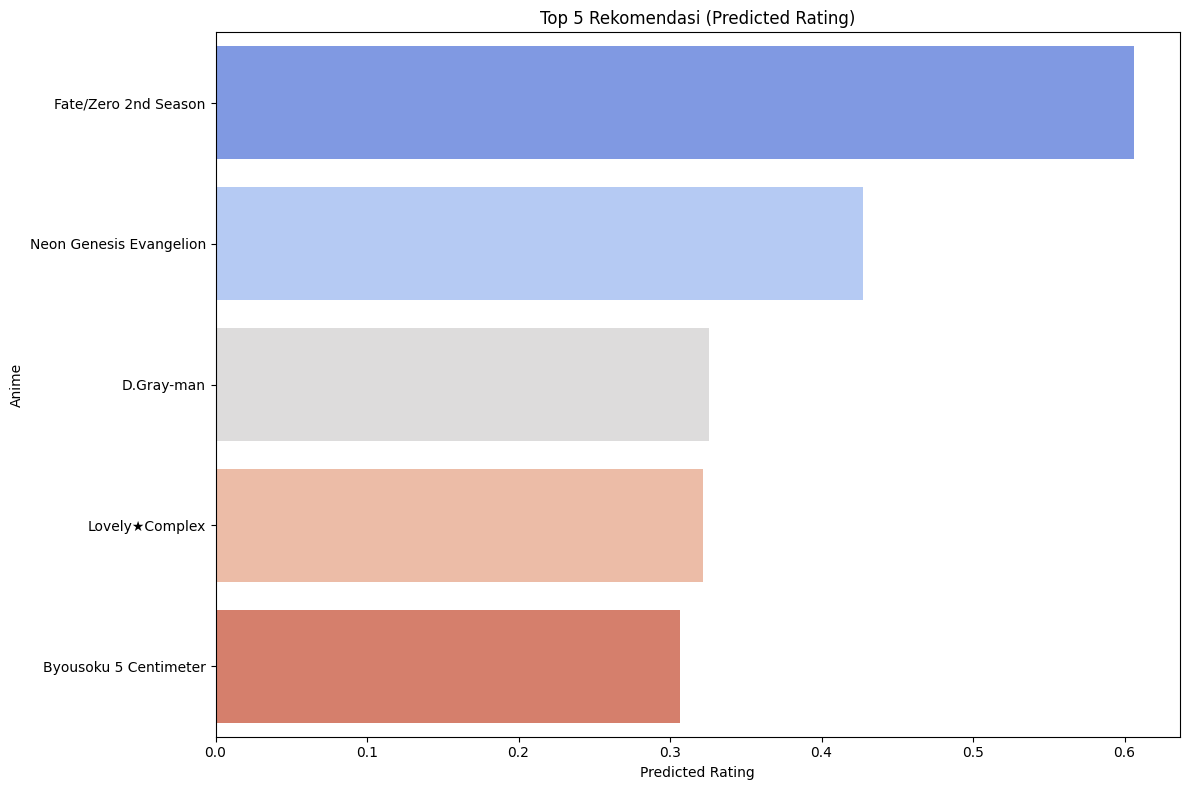

In [67]:
recommend_cf_verbose(user_id=rand_id,
                     pred_df=pred_df_svd,
                     df_anime=df_anime,
                     user_matrix=user_matrix_train,
                     top_n=5)

Percobaan 2

In [63]:
random.seed(46)
all_ids = df_rating_cf['user_id'].tolist()
rand_id = random.choice(all_ids)

=== Rekomendasi untuk user_id=57620 ===

--- Anime yang sudah dirating oleh user ---


,anime_id,name,genre,type,rating
0,22297,Fate/stay night: Unlimited Blade Works,"Action, Fantasy, Magic, Shounen, Supernatural",TV,8.42
1,6467,Detective Conan Movie 14: The Lost Ship in the...,"Action, Mystery, Police, Shounen",Movie,8.29
2,25879,Working!!!,"Comedy, Romance, Slice of Life",TV,8.18
3,339,Serial Experiments Lain,"Dementia, Drama, Mystery, Psychological, Sci-F...",TV,7.99
4,3750,Maria-sama ga Miteru 4th,"School, Shoujo, Shoujo Ai, Slice of Life",TV,7.97
5,29830,Tamayura: Sotsugyou Shashin Part 3 - Akogare,"Comedy, Drama, Slice of Life",Movie,7.88
6,30868,Ajin Part 1: Shoudou,"Action, Horror, Mystery, Seinen, Supernatural",Movie,7.84
7,21867,The Disappearance of Conan Edogawa: The Worst ...,"Adventure, Comedy, Mystery, Police, Shounen",Special,7.80
8,15439,"Kono Danshi, Ningyo Hiroimashita.","Fantasy, Shounen Ai",OVA,7.75
9,969,Tsubasa Chronicle 2nd Season,"Action, Adventure, Drama, Fantasy, Mystery, Ro...",TV,7.70



--- Top 5 Rekomendasi CF ---


,anime_id,name,genre,type,rating,predicted_rating
0,22535,Kiseijuu: Sei no Kakuritsu,"Action, Drama, Horror, Psychological, Sci-Fi, ...",TV,8.5900,0.6803
1,10793,Guilty Crown,"Action, Drama, Sci-Fi, Super Power",TV,7.8100,0.5808
2,7054,Kaichou wa Maid-sama!,"Comedy, Romance, School, Shoujo",TV,8.2600,0.5527
3,889,Black Lagoon,"Action, Seinen",TV,8.1700,0.5120
4,205,Samurai Champloo,"Action, Adventure, Comedy, Historical, Samurai...",TV,8.5000,0.4739


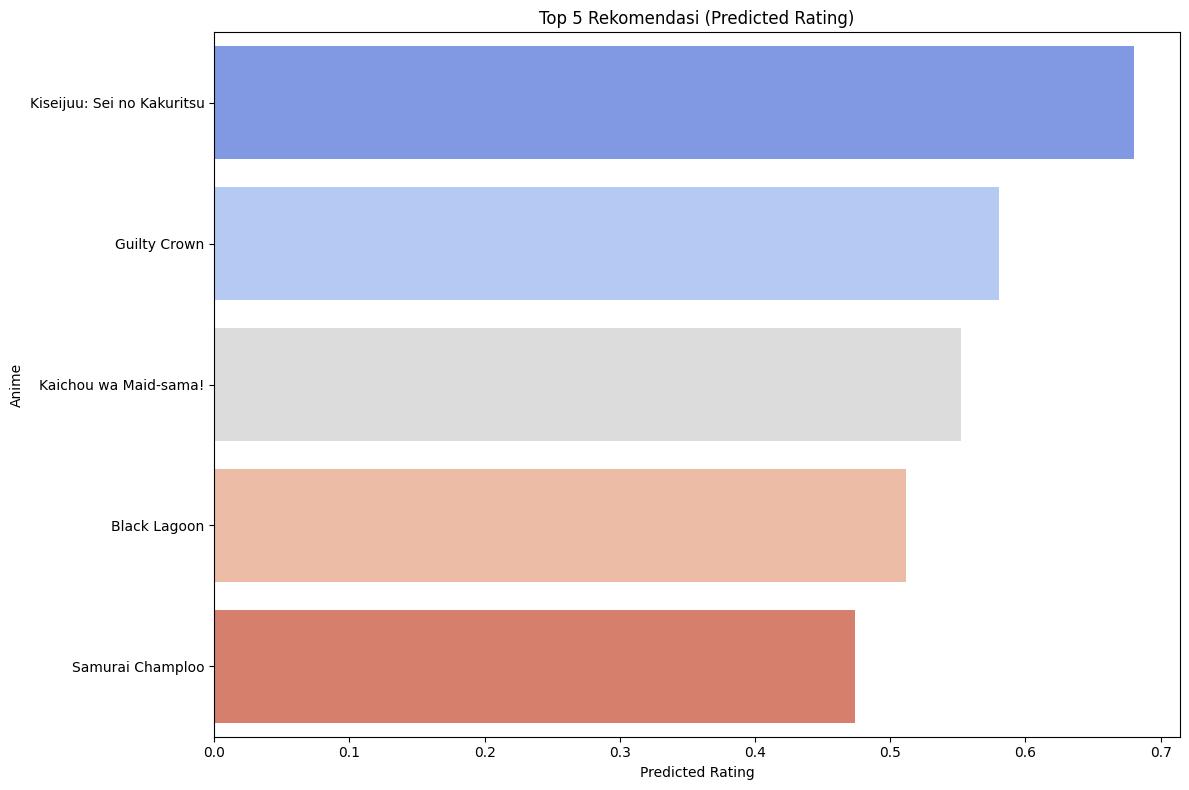

In [64]:
recommend_cf_verbose(user_id=rand_id,
                     pred_df=pred_df_svd,
                     df_anime=df_anime,
                     user_matrix=user_matrix_train,
                     top_n=5)

### **Kelebihan & Kekurangan Model Development dengan Collaborative Filtering**

Bagian ini mengembangkan model rekomendasi menggunakan pendekatan Collaborative Filtering (CF), khususnya metode Model-Based SVD. Pendekatan ini memiliki kelebihan dan kekurangan tersendiri dibandingkan dengan pendekatan Content-Based Filtering:
Kelebihan Collaborative Filtering (SVD):
1. Model berbasis SVD dapat menemukan hubungan antar item atau pengguna berdasarkan pola rating yang kompleks. Ini bisa merekomendasikan item yang secara konten mungkin tidak mirip dengan apa yang disukai pengguna sebelumnya, tetapi disukai oleh pengguna lain dengan selera serupa.
2. Model ini hanya memerlukan data interaksi (rating pengguna terhadap item). Anda tidak perlu memiliki deskripsi detail, genre, atau fitur lain dari item itu sendiri untuk membuat rekomendasi. Ini sangat berguna ketika fitur item sulit didapatkan atau diukur.
3. Dibandingkan Content-Based Filtering yang cenderung merekomendasikan item yang sangat mirip, CF dapat merekomendasikan item yang berbeda namun relevan, berdasarkan apa yang disukai oleh "tetangga" pengguna yang memiliki selera serupa.
4. Rekomendasi didasarkan pada "kebijaksanaan orang banyak". Jika banyak pengguna dengan selera serupa menyukai suatu item, model cenderung merekomendasikan item tersebut, bahkan jika fitur itemnya sendiri tidak sepenuhnya menjelaskan preferensi tersebut.

Kekurangan Collaborative Filtering (SVD):
1. Masalah Cold Start Pengguna dan Item:
  *   Jika pengguna baru belum memberikan rating yang cukup, model CF kesulitan memahami seleranya dan memberikan rekomendasi yang relevan. Matriks pengguna-item akan memiliki banyak nilai kosong untuk pengguna tersebut.
  *   Item yang baru ditambahkan ke database dan belum memiliki rating yang cukup dari banyak pengguna juga sulit direkomendasikan karena tidak ada data interaksi yang cukup untuk SVD menemukan faktor latennya.
2. Jika matriks rating sangat jarang (sparse) karena sebagian besar pengguna hanya merating sedikit item, performa model berbasis dekomposisi matriks seperti SVD bisa menurun. Sulit menemukan pola yang kuat dari data yang sangat sedikit.
3. Meskipun SVD menemukan faktor laten, seringkali sulit untuk memberikan makna intuitif atau menjelaskan mengapa model merekomendasikan item tertentu berdasarkan faktor-faktor abstrak tersebut.
4. Melatih model SVD pada matriks pengguna-item yang sangat besar bisa membutuhkan sumber daya komputasi yang signifikan dan waktu yang lama. Namun, teknik SVD yang dioptimalkan (seperti yang digunakan di sini, svds) dirancang untuk menangani matriks sparse yang besar.

Secara ringkas, Collaborative Filtering dengan SVD sangat baik dalam menemukan pola tersembunyi dan memberikan rekomendasi yang mengejutkan, tetapi rentan terhadap masalah data yang jarang (terutama untuk pengguna/item baru) dan hasilnya bisa kurang mudah dijelaskan dibandingkan dengan Content-Based Filtering.


### **Evaluasi Menggunakan RMSE**

Bagian ini bertujuan untuk mengevaluasi kinerja model Collaborative Filtering (CF) berbasis Singular Value Decomposition (SVD) yang telah dilatih sebelumnya. Metrik evaluasi yang digunakan adalah RMSE (Root Mean Squared Error).

In [71]:
actual_ratings = user_matrix_train[user_matrix_train > 0].stack().reset_index()
actual_ratings.columns = ['user_id', 'anime_id', 'actual_rating']
predicted_ratings = []
for index, row in actual_ratings.iterrows():
    user = row['user_id']
    anime = row['anime_id']

    if user in pred_df_svd.index and anime in pred_df_svd.columns:
        pred = pred_df_svd.loc[user, anime]
        predicted_ratings.append(pred)
    else:
        predicted_ratings.append(np.nan)

actual_ratings['predicted_rating'] = predicted_ratings

# Hapus baris dengan NaN jika ada
actual_ratings = actual_ratings.dropna()

Bagian evaluasi ini fokus pada pengukuran kinerja model rekomendasi berbasis Collaborative Filtering (CF) yang dilatih menggunakan teknik Singular Value Decomposition (SVD). Untuk mengukur seberapa baik model ini dalam memprediksi rating pengguna, digunakan metrik Root Mean Squared Error (RMSE). Pertama-tama mempersiapkan data dengan mengekstrak semua rating eksplisit (nilai lebih besar dari 0) dari matriks pelatihan dan menyusunnya dalam format tabel yang mudah dikelola, di mana setiap baris mewakili satu interaksi rating pengguna-anime beserta nilai rating aktualnya. Kemudian, secara iteratif mencari rating yang diprediksi oleh model SVD untuk setiap interaksi pengguna-anime yang memiliki rating aktual, mencocokkannya berdasarkan ID pengguna dan anime.

Hasil prediksi ini disimpan dalam list, dan jika prediksi tidak tersedia untuk pasangan tertentu, ditandai dengan nilai kosong (NaN). List prediksi ini kemudian ditambahkan sebagai kolom baru pada tabel rating aktual. Langkah terakhir dalam persiapan data adalah menghapus baris-baris yang memiliki nilai kosong (akibat prediksi yang tidak tersedia), memastikan bahwa hanya data dengan pasangan rating aktual dan prediksi yang lengkap yang akan digunakan dalam perhitungan. Setelah data disiapkan, baris kode utama evaluasi menghitung RMSE. Ini dilakukan dengan mengambil akar kuadrat dari Mean Squared Error (MSE) antara kolom rating aktual dan kolom rating prediksi yang baru saja dibuat. Nilai MSE dihitung dengan merata-ratakan kuadrat perbedaan antara setiap rating aktual dan rating prediksinya.

In [72]:
# Hitung RMSE
rmse_cf = np.sqrt(mean_squared_error(actual_ratings['actual_rating'], actual_ratings['predicted_rating']))

print(f"RMSE for Collaborative Filtering (SVD Model): {rmse_cf:.4f}")

RMSE for Collaborative Filtering (SVD Model): 7.2628


Hasil RMSE yang diperoleh kemudian dicetak ke layar, dibulatkan hingga empat angka desimal, memberikan nilai tunggal yang merangkum rata-rata "kesalahan" prediksi model dalam skala rating yang sama (0-10). Nilai RMSE yang lebih rendah menunjukkan bahwa prediksi model rata-rata lebih dekat dengan rating sebenarnya, mengindikasikan performa prediksi yang lebih baik.

Output RMSE for Collaborative Filtering (SVD Model): 7.2628 mengindikasikan bahwa model Collaborative Filtering berbasis SVD yang dilatih, dengan konfigurasi data dan parameter saat ini, menghasilkan prediksi rating yang memiliki tingkat kesalahan rata-rata cukup besar. Ini menyarankan bahwa model ini mungkin tidak cukup akurat untuk memprediksi rating eksplisit pengguna secara andal pada data yang dievaluasi. Untuk meningkatkan performa, mungkin perlu mempertimbangkan menggunakan dataset rating yang lebih besar, menyesuaikan parameter model SVD (seperti k), atau mencoba teknik CF lainnya.